In [1]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


## Load in reference data, normalized and cell type + sample corrected

In [3]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/monkey/cell2location/multi_ref_annot'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map/N2_alpha200_cellxgene_filtered_genesets'

In [4]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

In [5]:
## convert mouse gene name in reference to human names

import gseapy as gp
from gseapy import Biomart
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])


# get a dict symbol mappings
m2h_dict = {}
for i, row in m2h.loc[:,["external_gene_name", "hsapiens_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    m2h_dict[row['external_gene_name']] = row["hsapiens_homolog_associated_gene_name"]

m2h_genes_input = adata_ref.var['features']
m2h_genes_output = []

for gene in m2h_genes_input:
    if gene in m2h_dict.keys():
        m2h_genes_output.append(m2h_dict[gene])
    else:
        m2h_genes_output.append(gene)

adata_ref.var.index = m2h_genes_output
adata_ref.var['features'] = m2h_genes_output
adata_ref.var['SYMBOL'] = m2h_genes_output
adata_ref.varm['means_per_cluster_mu_fg'].index = m2h_genes_output
adata_ref.varm['q05_per_cluster_mu_fg'].index = m2h_genes_output
adata_ref.varm['q95_per_cluster_mu_fg'].index = m2h_genes_output
adata_ref.varm['stds_per_cluster_mu_fg'].index = m2h_genes_output

In [6]:
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File                                                                                                      
         /home/ssobti/projects/farnaz_spatial/output_data/monkey/cell2location/multi_ref_annot/reference_signatures
         /model.pt already downloaded                                                                              


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/69:   1%|▏         | 1/69 [00:04<05:07,  4.52s/it, v_num=1, elbo_train=1.64e+9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/69:   1%|▏         | 1/69 [00:04<05:08,  4.54s/it, v_num=1, elbo_train=1.64e+9]


In [7]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]



Adipocyte_progenitors  Adipocytes   B_cells  Brown_adipocytes  \
XKR4                 0.856888    1.333403  0.000017          0.001237   
SOX17                0.000777    0.000151  0.000249          0.002336   
MRPL15               0.126718    0.252087  0.043601          2.367598   
LYPLA1               0.080591    0.257422  0.027917          1.354572   
TCEA1                0.185279    0.276333  0.027876          0.882814   

        Endothelial_cells  
XKR4             0.012203  
SOX17            1.495620  
MRPL15           0.171279  
LYPLA1           0.146360  
TCEA1            0.317588

In [8]:
inf_aver

Adipocyte_progenitors  Adipocytes   B_cells  Brown_adipocytes  \
XKR4                  0.856888    1.333403  0.000017          0.001237   
SOX17                 0.000777    0.000151  0.000249          0.002336   
MRPL15                0.126718    0.252087  0.043601          2.367598   
LYPLA1                0.080591    0.257422  0.027917          1.354572   
TCEA1                 0.185279    0.276333  0.027876          0.882814   
...                        ...         ...       ...               ...   
CCR8                  0.000044    0.000173  0.000103          0.004542   
CCDC152               0.039889    2.767001  0.000177          0.022622   
FBXO40                0.000094    0.000646  0.000328          0.001754   
EXTL1                 0.000188    0.000174  0.003647          0.004905   
S100G                 0.001088    0.003226  0.000275          0.104064   

         Endothelial_cells  Eosinophils  Epithelial_cells  \
XKR4              0.012203     0.001720          0.447235   
SOX17             1.495620     0.007271          0.000531   
MRPL15            0.171279     0.016527          0.290706   
LYPLA1            0.146360     0.025678          0.302260   
TCEA1             0.317588     0.009997          0.285317   
...                    ...          ...               ...   
CCR8              0.000237     0.001324          0.000398   
CCDC152           0.008079     0.001701          0.000231   
FBXO40            0.001043     0.000819          0.002556   
EXTL1             0.000550     0.001639          0.274074   
S100G             0.004959     0.002940          0.008753   

         Lymphatic_endothelial_cells  Macrophages  Mast_cells  Mesothelium  \
XKR4                        0.027294     0.000071    0.014462     2.877686   
SOX17                       0.011183     0.000270    0.007895     0.000698   
MRPL15                      0.226614     0.145973    0.031073     0.169864   
LYPLA1                      0.217248     0.085147    0.065710     0.182940   
TCEA1                       0.355022     0.194744    0.039495     0.207420   
...                              ...          ...         ...          ...   
CCR8                        0.001047     0.000055    0.013905     0.000485   
CCDC152                     0.046807     0.141066    0.013182     0.001394   
FBXO40                      0.001625     0.006626    0.007780     0.000163   
EXTL1                       0.001722     0.001000    0.033688     0.050081   
S100G                       0.002368     0.004545    0.070094     0.000349   

         NK_cells  Neutrophils  Pericytes  Schwan_cells  Skeletal_muscle  \
XKR4     0.000116     0.000547   0.231026      0.032447         0.012408   
SOX17    0.001067     0.001689   0.003726      0.002905         0.012651   
MRPL15   0.041783     0.001560   0.110467      0.065814         0.327648   
LYPLA1   0.031676     0.016715   0.099241      0.052962         0.234781   
TCEA1    0.019747     0.002272   0.144656      0.183290         0.203325   
...           ...          ...        ...           ...              ...   
CCR8     0.000432     0.000620   0.000967      0.000920         0.011439   
CCDC152  0.000802     0.000587   0.012783      0.005381         0.015925   
FBXO40   0.000211     0.001157   0.001230      0.000455         2.641539   
EXTL1    0.000342     0.000656   0.000934      0.003674         0.088841   
S100G    0.000126     0.000810   0.000591      0.001119         0.027226   

          T_cells     Tregs  Vascular_smooth_muscle  white adipocytes  
XKR4     0.000030  0.000917                0.909910          7.280010  
SOX17    0.000184  0.006084                0.003812          0.000480  
MRPL15   0.056897  0.295870                0.306349          0.588513  
LYPLA1   0.034007  0.129567                0.169079          0.537039  
TCEA1    0.034260  0.204895                0.364905          0.654891  
...           ...       ...                     ...               ...  
CCR8     0.004128  0.013304      

In [9]:
adata_ref.uns['mod']['factor_names']

array(['Adipocyte_progenitors', 'Adipocytes', 'B_cells',
       'Brown_adipocytes', 'Endothelial_cells', 'Eosinophils',
       'Epithelial_cells', 'Lymphatic_endothelial_cells', 'Macrophages',
       'Mast_cells', 'Mesothelium', 'NK_cells', 'Neutrophils',
       'Pericytes', 'Schwan_cells', 'Skeletal_muscle', 'T_cells', 'Tregs',
       'Vascular_smooth_muscle', 'white adipocytes'], dtype=object)

In [10]:
adata_ref.varm['means_per_cluster_mu_fg']

means_per_cluster_mu_fg_Adipocyte_progenitors  \
XKR4                                          0.856888   
SOX17                                         0.000777   
MRPL15                                        0.126718   
LYPLA1                                        0.080591   
TCEA1                                         0.185279   
...                                                ...   
CCR8                                          0.000044   
CCDC152                                       0.039889   
FBXO40                                        0.000094   
EXTL1                                         0.000188   
S100G                                         0.001088   

         means_per_cluster_mu_fg_Adipocytes  means_per_cluster_mu_fg_B_cells  \
XKR4                               1.333403                         0.000017   
SOX17                              0.000151                         0.000249   
MRPL15                             0.252087                         0.043601   
LYPLA1                             0.257422                         0.027917   
TCEA1                              0.276333                         0.027876   
...                                     ...                              ...   
CCR8                               0.000173                         0.000103   
CCDC152                            2.767001                         0.000177   
FBXO40                             0.000646                         0.000328   
EXTL1                              0.000174                         0.003647   
S100G                              0.003226                         0.000275   

         means_per_cluster_mu_fg_Brown_adipocytes  \
XKR4                                     0.001237   
SOX17                                    0.002336   
MRPL15                                   2.367598   
LYPLA1                                   1.354572   
TCEA1                                    0.882814   
...                                           ...   
CCR8                                     0.004542   
CCDC152                                  0.022622   
FBXO40                                   0.001754   
EXTL1                                    0.004905   
S100G                                    0.104064   

         means_per_cluster_mu_fg_Endothelial_cells  \
XKR4                                      0.012203   
SOX17                                     1.495620   
MRPL15                                    0.171279   
LYPLA1                                    0.146360   
TCEA1                                     0.317588   
...                                            ...   
CCR8                                      0.000237   
CCDC152                                   0.008079   
FBXO40                                    0.001043   
EXTL1                                     0.000550   
S100G                                     0.004959   

         means_per_cluster_mu_fg_Eosinophils  \
XKR4                                0.001720   
SOX17                               0.007271   
MRPL15                              0.016527   
LYPLA1                              0.025678   
TCEA1                               0.009997   
...                                      ...   
CCR8                                0.001324   
CCDC152                             0.001701   
FBXO40                              0.000819   
EXTL1                               0.001639   
S100G                               0.002940   

         means_per_cluster_mu_fg_Epithelial_cells  \
XKR4                                     0.447235   
SOX17                                    0.000531   
MRPL15                                   0.290706   
LYPLA1                                   0.302260   
TCEA1                                    0.285317   
...                                           ...   
CCR8                                     0.000398   
CCDC152                                  0.000231   
FBXO40     

In [11]:
## filter out all genes not in gene sets for each cell type from cellxgene 
# (note not 1 or 2 cell types not present in geneset but enough total genes present to deconvolute)
cellxgene_genesets = pd.read_csv('/home/ssobti/projects/farnaz_spatial/data/monkey_data/cellxgene_gene_sets/list_of_celltypes_and_markers.csv')
cellxgene_genes = cellxgene_genesets['gene']
intersected_genes = set(inf_aver.index).intersection(set(cellxgene_genes))
inf_aver = inf_aver.loc[intersected_genes,:]
inf_aver ## note there are about 13 duplicate genes in the rows here

Adipocyte_progenitors  Adipocytes   B_cells  Brown_adipocytes  \
LPIN1                  0.050843    7.826736  0.004878          5.379598   
TNFSF10                0.001143    0.000162  0.000691          0.006541   
SIK2                   0.070853   51.836369  0.091251          0.881754   
PPARGC1A               0.023666    0.894645  0.003868          1.683218   
ELOVL5                 0.090559    0.372567  0.066465          1.794635   
...                         ...         ...       ...               ...   
KCNJ8                  0.007722    0.000265  0.000044          0.001956   
S100A8                 0.003467    0.000095  0.000238          0.098153   
NTM                    0.030776    1.355641  0.000049          0.011923   
RPS29                  0.016116    0.020818  0.028402         27.484779   
MYH11                  0.030833    0.001275  0.000223          0.136794   

          Endothelial_cells  Eosinophils  Epithelial_cells  \
LPIN1              0.066355     0.086702          0.432654   
TNFSF10            0.345300     0.014936          0.186480   
SIK2               0.084363     0.091307          0.414131   
PPARGC1A           0.013926     0.003042          0.988692   
ELOVL5             0.514771     0.175920          0.544620   
...                     ...          ...               ...   
KCNJ8              0.085872     0.000846          0.000213   
S100A8             0.062799     0.122018          0.000814   
NTM                0.005858     0.000907          0.039396   
RPS29              0.028599     0.039020          0.042396   
MYH11              1.673044     0.034079          0.405069   

          Lymphatic_endothelial_cells  Macrophages  Mast_cells  Mesothelium  \
LPIN1                        0.087103     0.277787    0.068252     0.006691   
TNFSF10                      0.199174     0.010171    0.085131     0.007521   
SIK2                         0.068976     0.423105    0.086377     3.333029   
PPARGC1A                     0.022836     0.002603    0.008114     0.000886   
ELOVL5                       0.621679     0.199788    0.041705     0.210255   
...                               ...          ...         ...          ...   
KCNJ8                        0.135656     0.000142    0.009023     0.015156   
S100A8                       0.009448     0.001404    0.027931     0.002439   
NTM                          0.001226     0.000138    0.008917     0.186313   
RPS29                        0.002402     0.071864    0.040162     0.029925   
MYH11                        0.124080     0.000918    0.008666     0.061450   

          NK_cells  Neutrophils  Pericytes  Schwan_cells  Skeletal_muscle  \
LPIN1     0.310410     0.007644   0.129326      0.112996         3.121669   
TNFSF10   0.012878     0.002175   0.002087      0.001202         0.063569   
SIK2      0.131562     0.045660   0.094635      0.051662         1.066730   
PPARGC1A  0.018258     0.000911   0.018015      0.008478         2.057081   
ELOVL5    0.076786     0.032544   0.196440      0.083797         0.014630   
...            ...          ...        ...           ...              ...   
KCNJ8     0.055142     0.001053   3.330921      0.001749         0.014044   
S100A8    0.001092    32.731297   0.084644      0.018195         0.010085   
NTM       0.000108     0.000633   0.055441      0.005619         0.007331   
RPS29     0.016175     0.009090   0.017130      0.009901         0.047790   
MYH11     0.002454     0.025270   3.715860      0.007117         0.012317   

            T_cells     Tregs  Vascular_smooth_muscle  white adipocytes  
LPIN1      0.081866  0.130487                0.179089         14.043059  
TNFSF10    0.012614  0.108660                0.000788          0.000526  
SIK2       0.091529  0.153551                0.189777         42.729660  
PPARGC1A   0.000365  0.002534                0.098236          1.076499  
ELOVL5     0.140684  0.432624                0.486316          0.736918  
...             ...       ...                 

## Loading Visium data

In [12]:
# Set paths to data and results used through the document:
sp_data_folder = '/home/ssobti/projects/farnaz_spatial/data/monkey_data/unpacked_data/'

In [13]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs',
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'visium.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder))

#### change the slide identity key in .uns so they aren't the repeats between slides ####
## new names:
## 096-count-A1: 1149_G
## 096-count-D1: 1572_G
## 327-count-A1: 1080_T
## 327-count-D1: 1080_B

slides[0].uns['spatial']['1149G_A1_096'] = slides[0].uns['spatial'].pop('count-A1')
slides[1].uns['spatial']['1572G_D1_096'] = slides[1].uns['spatial'].pop('count-D1')
slides[2].uns['spatial']['1080T_A1_327'] = slides[2].uns['spatial'].pop('count-A1')
slides[3].uns['spatial']['1080B_D1_327'] = slides[3].uns['spatial'].pop('count-D1')

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [14]:
adata_vis.var

feature_types  genome   SYMBOL     mt  \
ENSEMBL                                                    
ENSG00000187634  Gene Expression  GRCh38   SAMD11  False   
ENSG00000188976  Gene Expression  GRCh38    NOC2L  False   
ENSG00000187961  Gene Expression  GRCh38   KLHL17  False   
ENSG00000187583  Gene Expression  GRCh38  PLEKHN1  False   
ENSG00000187642  Gene Expression  GRCh38    PERM1  False   
...                          ...     ...      ...    ...   
ENSG00000212907  Gene Expression  GRCh38  MT-ND4L  False   
ENSG00000198886  Gene Expression  GRCh38   MT-ND4  False   
ENSG00000198786  Gene Expression  GRCh38   MT-ND5  False   
ENSG00000198695  Gene Expression  GRCh38   MT-ND6  False   
ENSG00000198727  Gene Expression  GRCh38   MT-CYB  False   

                 n_cells_by_counts-1080B_D1_327  mean_counts-1080B_D1_327  \
ENSEMBL                                                                     
ENSG00000187634                             105                  0.041590   
ENSG00000188976                              82                  0.031285   
ENSG00000187961                             104                  0.040118   
ENSG00000187583                               6                  0.002208   
ENSG00000187642                              17                  0.006257   
...                                         ...                       ...   
ENSG00000212907                               0                  0.000000   
ENSG00000198886                               0                  0.000000   
ENSG00000198786                               0                  0.000000   
ENSG00000198695                               0                  0.000000   
ENSG00000198727                               0                  0.000000   

                 log1p_mean_counts-1080B_D1_327  \
ENSEMBL                                           
ENSG00000187634                        0.040748   
ENSG00000188976                        0.030805   
ENSG00000187961                        0.039334   
ENSG00000187583                        0.002206   
ENSG00000187642                        0.006237   
...                                         ...   
ENSG00000212907                        0.000000   
ENSG00000198886                        0.000000   
ENSG00000198786                        0.000000   
ENSG00000198695                        0.000000   
ENSG00000198727                        0.000000   

                 pct_dropout_by_counts-1080B_D1_327  \
ENSEMBL                                               
ENSG00000187634                           96.135444   
ENSG00000188976                           96.981965   
ENSG00000187961                           96.172249   
ENSG00000187583                           99.779168   
ENSG00000187642                           99.374310   
...                                             ...   
ENSG00000212907                          100.000000   
ENSG00000198886                          100.000000   
ENSG00000198786                          100.000000   
ENSG00000198695                          100.000000   
ENSG00000198727                          100.000000   

                 total_counts-1080B_D1_327  log1p_total_counts-1080B_D1_327  \
ENSEMBL                                                                       
ENSG00000187634                      113.0                         4.736198   
ENSG00000188976                       85.0                         4.454347   
ENSG00000187961                      109.0                         4.700480   
ENSG00000187583                        6.0                         1.945910   
ENSG00000187642                       17.0                         2.890372   
...                                    ...                              ...   
ENSG00000212907                        0.0                         0.000000   
ENSG00000198886                        0.0                         0.000000   
ENSG00000198786                        0.0                        

In [15]:
adata_vis.obs

in_tissue  array_row  array_col  \
spot_id                                                            
1149G_A1_096_AACACTTGGCAAGGAA-1          1         47         71   
1149G_A1_096_AACAGGATTCATAGTT-1          1         49         43   
1149G_A1_096_AACAGGTTATTGCACC-1          1         28         86   
1149G_A1_096_AACAGGTTCACCGAAG-1          1         51         41   
1149G_A1_096_AACATACTCATATGCG-1          1         50          6   
...                                    ...        ...        ...   
1080B_D1_327_TGTTCTGCTCTGTCGT-1          1         39         39   
1080B_D1_327_TGTTGCGTCCAAGATT-1          1         51         65   
1080B_D1_327_TGTTGGAACCTTCCGC-1          1         35         35   
1080B_D1_327_TGTTGGAACGAGGTCA-1          1         28         72   
1080B_D1_327_TGTTGGCCTACACGTG-1          1         37        127   

                                       sample  n_genes_by_counts  \
spot_id                                                            
1149G_A1_096_AACACTTGGCAAGGAA-1  1149G_A1_096                 24   
1149G_A1_096_AACAGGATTCATAGTT-1  1149G_A1_096                 29   
1149G_A1_096_AACAGGTTATTGCACC-1  1149G_A1_096                293   
1149G_A1_096_AACAGGTTCACCGAAG-1  1149G_A1_096                 16   
1149G_A1_096_AACATACTCATATGCG-1  1149G_A1_096                 78   
...                                       ...                ...   
1080B_D1_327_TGTTCTGCTCTGTCGT-1  1080B_D1_327                120   
1080B_D1_327_TGTTGCGTCCAAGATT-1  1080B_D1_327                675   
1080B_D1_327_TGTTGGAACCTTCCGC-1  1080B_D1_327                180   
1080B_D1_327_TGTTGGAACGAGGTCA-1  1080B_D1_327                467   
1080B_D1_327_TGTTGGCCTACACGTG-1  1080B_D1_327               3395   

                                 log1p_n_genes_by_counts  total_counts  \
spot_id                                                                  
1149G_A1_096_AACACTTGGCAAGGAA-1                 3.218876          42.0   
1149G_A1_096_AACAGGATTCATAGTT-1                 3.401197          32.0   
1149G_A1_096_AACAGGTTATTGCACC-1                 5.683580         411.0   
1149G_A1_096_AACAGGTTCACCGAAG-1                 2.833213          20.0   
1149G_A1_096_AACATACTCATATGCG-1                 4.369448          96.0   
...                                                  ...           ...   
1080B_D1_327_TGTTCTGCTCTGTCGT-1                 4.795791         132.0   
1080B_D1_327_TGTTGCGTCCAAGATT-1                 6.516193         855.0   
1080B_D1_327_TGTTGGAACCTTCCGC-1                 5.198497         203.0   
1080B_D1_327_TGTTGGAACGAGGTCA-1                 6.148468         553.0   
1080B_D1_327_TGTTGGCCTACACGTG-1                 8.130354        7436.0   

                                 log1p_total_counts  \
spot_id                                               
1149G_A1_096_AACACTTGGCAAGGAA-1            3.761200   
1149G_A1_096_AACAGGATTCATAGTT-1            3.496508   
1149G_A1_096_AACAGGTTATTGCACC-1            6.021023   
1149G_A1_096_AACAGGTTCACCGAAG-1            3.044523   
1149G_A1_096_AACATACTCATATGCG-1            4.574711   
...                                             ...   
1080B_D1_327_TGTTCTGCTCTGTCGT-1            4.890349   
1080B_D1_327_TGTTGCGTCCAAGATT-1            6.752270   
1080B_D1_327_TGTTGGAACCTTCCGC-1            5.318120   
1080B_D1_327_TGTTGGAACGAGGTCA-1            6.317165   
1080B_D1_327_TGTTGGCCTACACGTG-1            8.914223   

                                 pct_counts_in_top_50_genes  \
spot_id                                                       
1149G_A1_096_AACACTTGGCAAGGAA-1                  100.000000   
1149G_A1_096_AACAGGATTCATAGTT-1                  100.000000   
1149G_A1_096_AACAGGTTATTGCACC-1                   33.333333   
1149G_A1_096_AACAGGTTCACCGAAG-1                  100.000000   
1149G_A1_096_AACATACTCATATGCG-1                   70.833333   
...                                                     ...   
1080B_D1_327_TGTTCTGCTCTGTCGT-1                   46.969697   
1080B_D1_327_TGTT

In [16]:
adata_vis.var.set_index('SYMBOL', drop=False, inplace=True)
adata_vis.var.index.name = None

In [17]:
## average or get rid of non-unique gene symbols now that you've gotten rid of ENSEMBL IDs
print('total genes:' + str(len(adata_vis.var.index)))
print('unique genes:' + str(len(np.unique(adata_vis.var.index))))
print('duplicates to make unique:' + str(len(adata_vis.var.index)-len(np.unique(adata_vis.var.index))))


total genes:18085
unique genes:18082
duplicates to make unique:3


In [18]:
adata_vis.var_names_make_unique()

In [19]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [20]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()

inf_aver_copy = inf_aver.copy() ## infer_aver has non-unique rownames -- fix
inf_aver_copy['genes'] = inf_aver_copy.index
inf_aver_copy = inf_aver_copy.groupby('genes').mean().reset_index() ## average expression of genes with non-unique symbols
inf_aver_copy.index = inf_aver_copy['genes'] 
inf_aver_copy.index.name = None
inf_aver_copy = inf_aver_copy.drop(columns=['genes'])
inf_aver = inf_aver_copy.loc[intersect, :].copy()  
inf_aver

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")


## Cell2location spatial mapping

In [21]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=2,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 12382 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │  284  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 1149G_A1_096 │          0          │
│                     │ 1572G_D1_096 │          1          │
│                     │ 1080T_A1_327 │          2          │
│                     │ 1080B_D1_327 │          3          │
└─────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3000/3000: 100%|██████████| 3000/3000 [11:45<00:00,  3.88it/s, v_num=1, elbo_train=1.65e+6]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [11:45<00:00,  4.25it/s, v_num=1, elbo_train=1.65e+6]


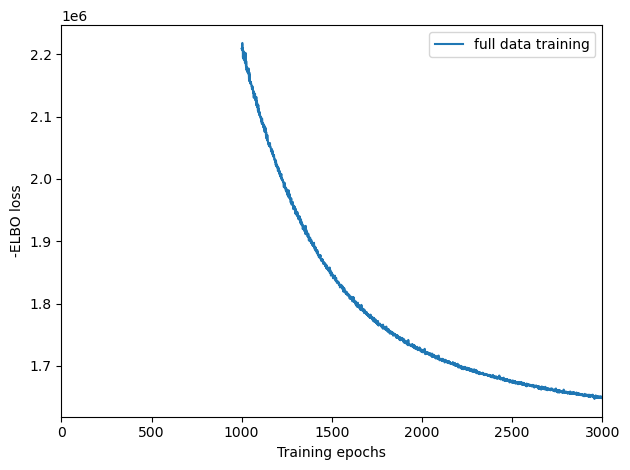

In [22]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [23]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:40<00:00, 24.74it/s]


'/home/ssobti/projects/farnaz_spatial/output_data/monkey/cell2location/multi_ref_annot/cell2location_map/N2_alpha200_cellxgene_filtered_genesets/sp.h5ad'

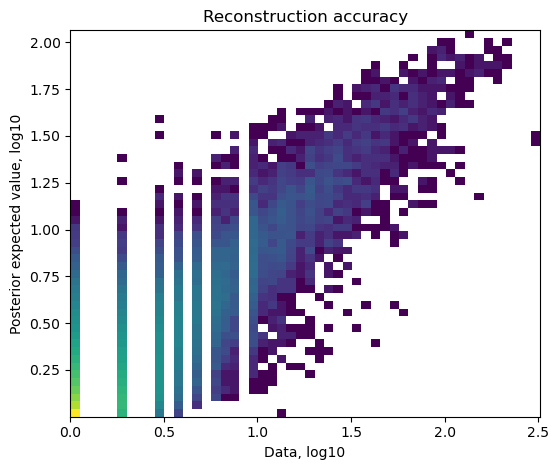

In [24]:
mod.plot_QC()

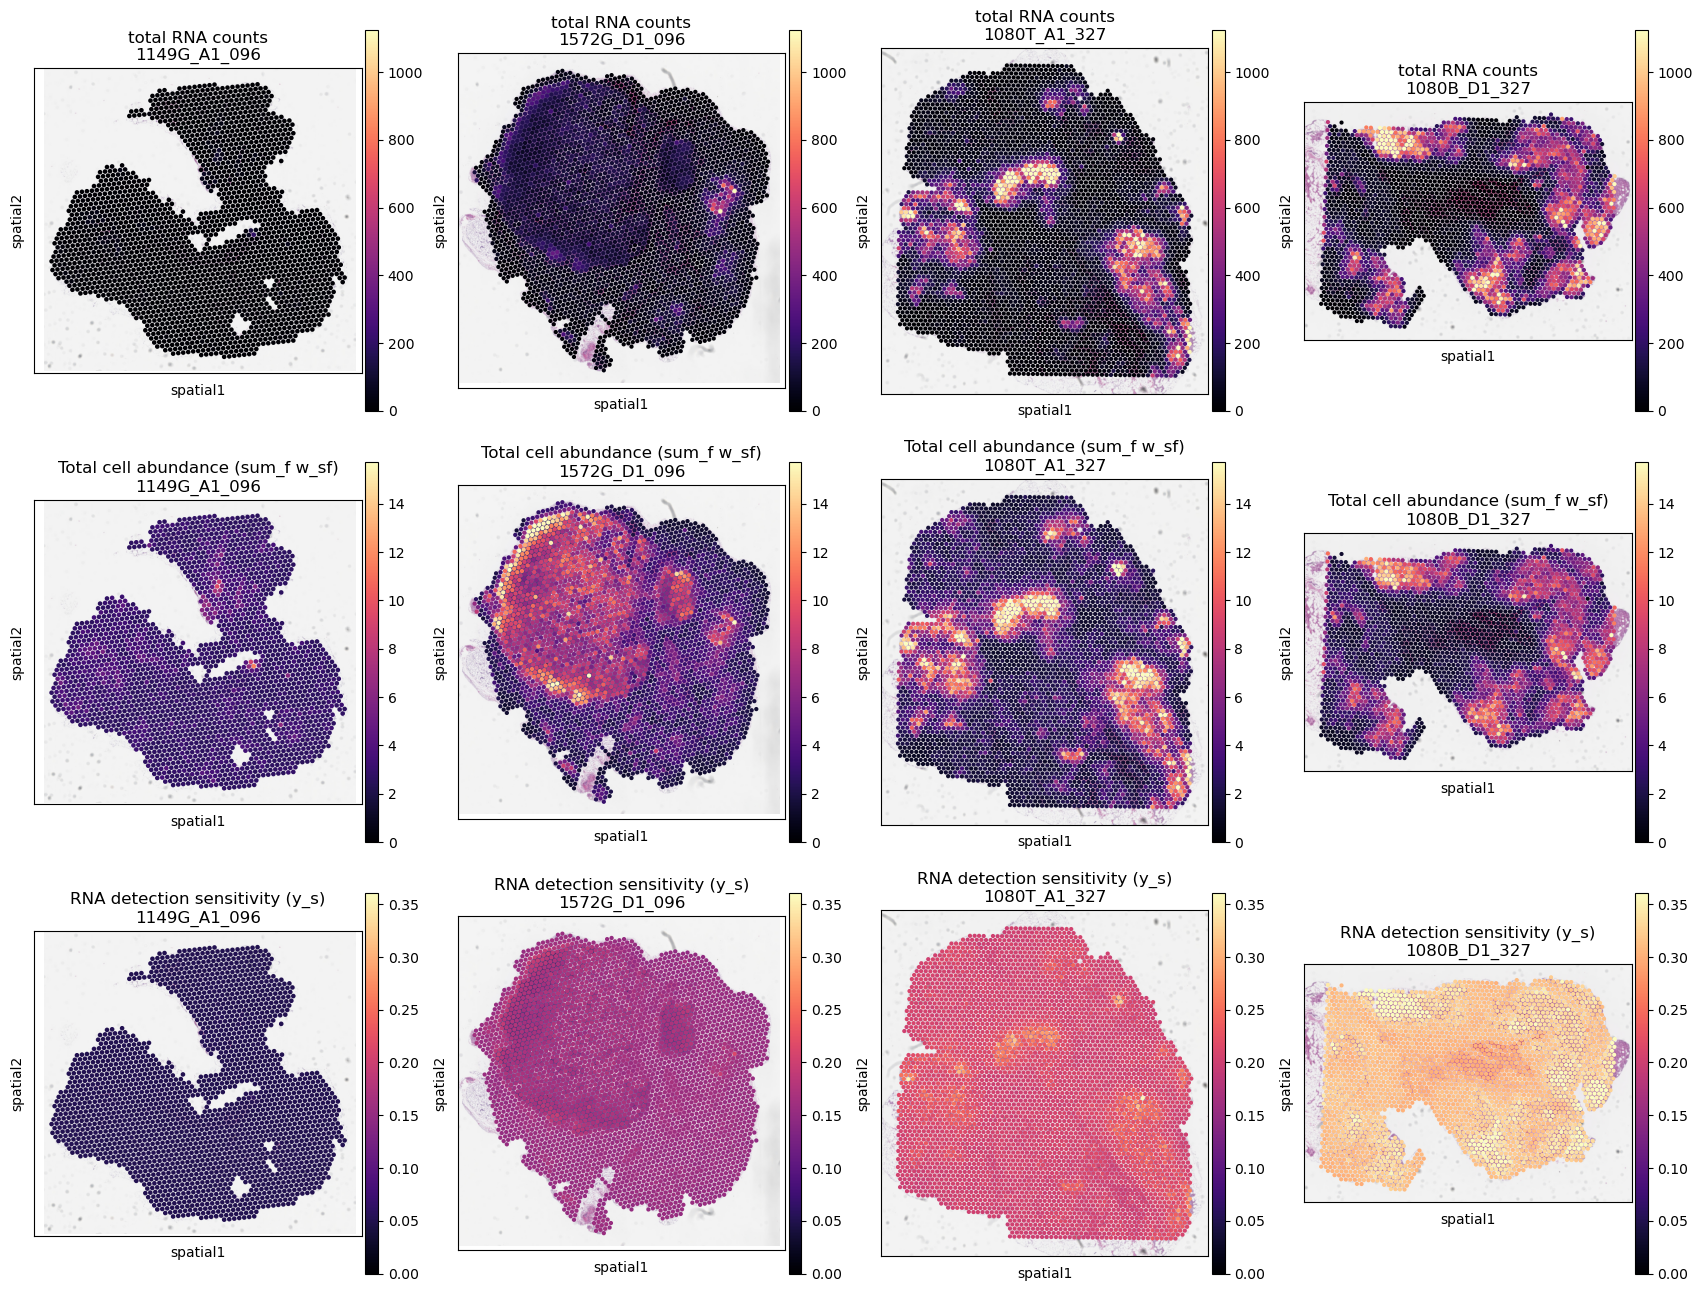

In [25]:
fig = mod.plot_spatial_QC_across_batches()

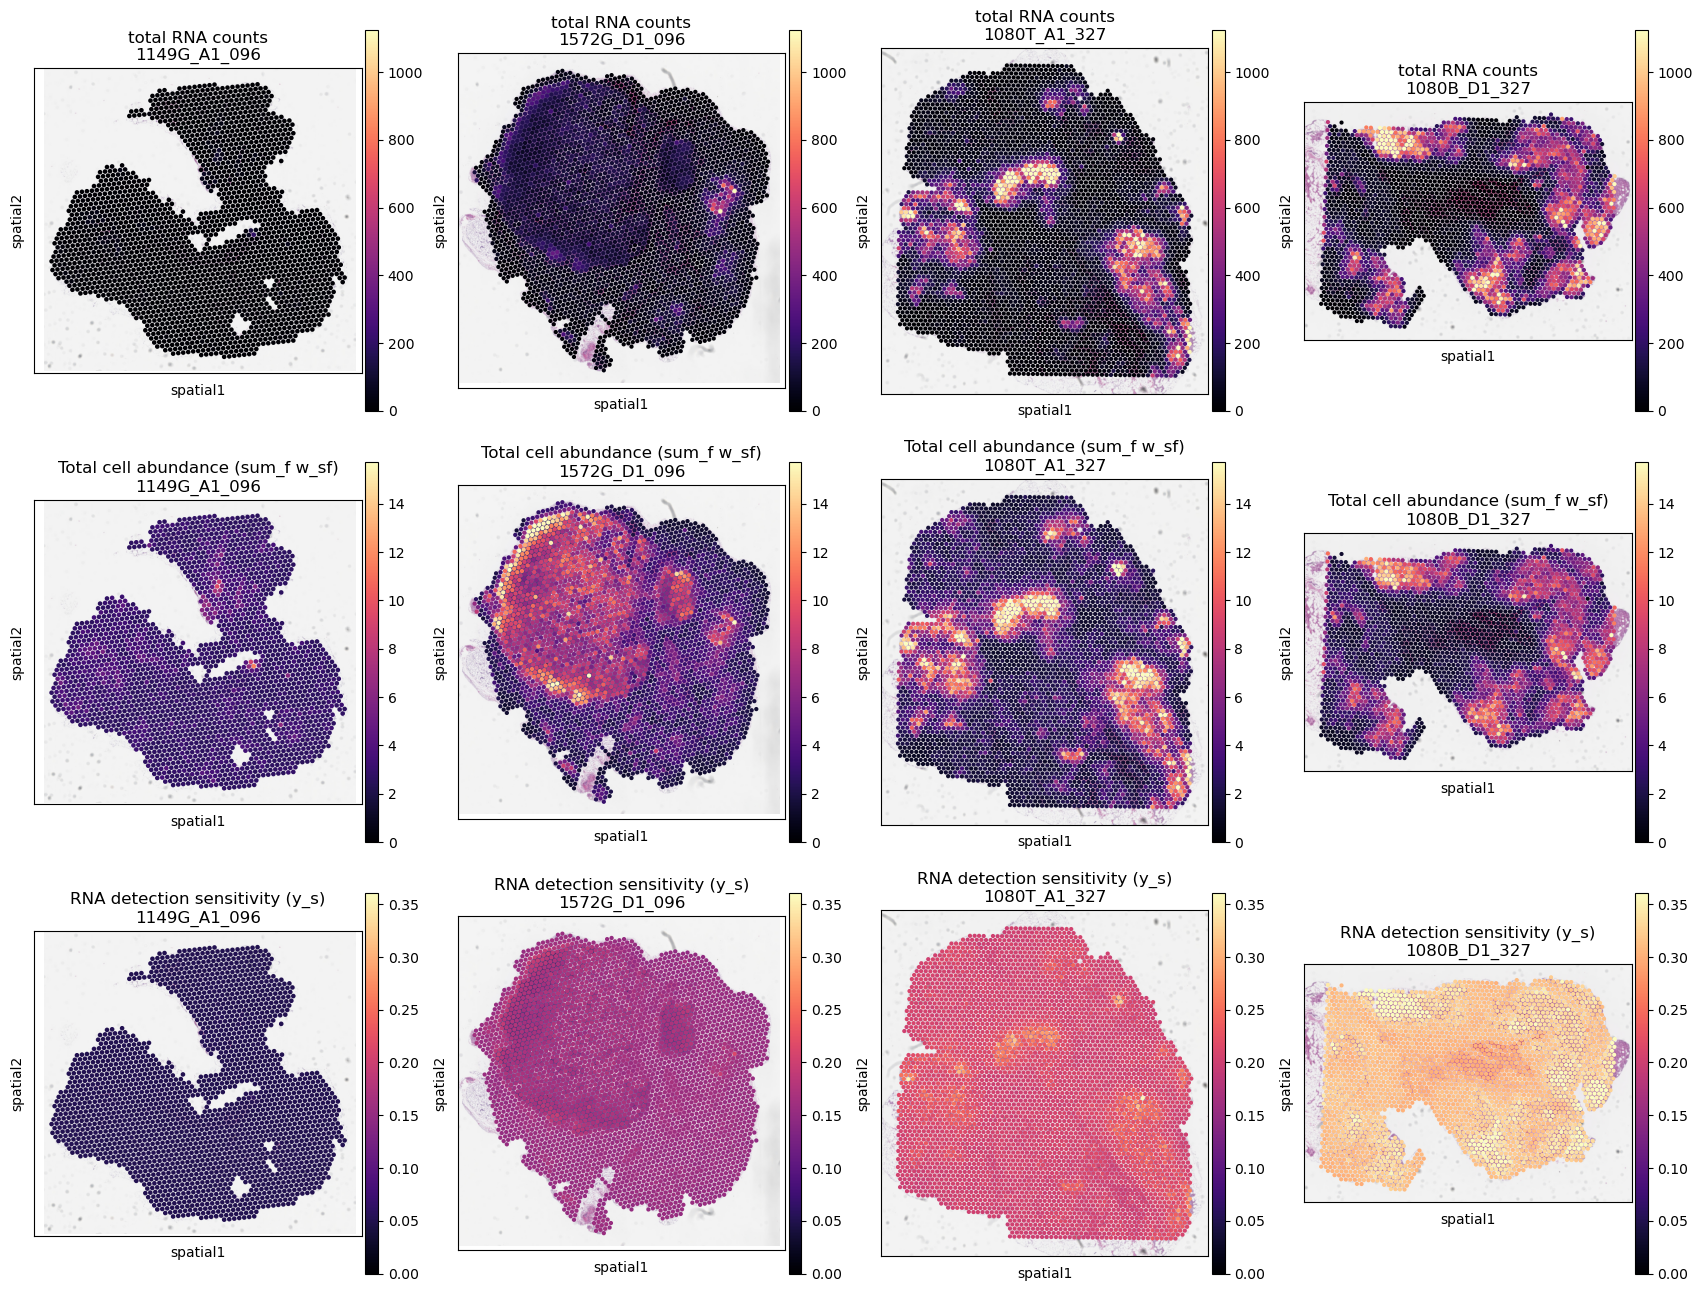

In [26]:
fig